# On-Device Continual Learning - EMNIST Classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from collections import defaultdict, Counter
import random

## Model

### Load Dataset

In [2]:
(t_ds_train, t_ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

ds_full = t_ds_train.concatenate(t_ds_test)
label_map = list(string.ascii_uppercase)

### Preprocess Dataset

In [3]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # image = tf.expand_dims(image, -1)
    label = label - 1
    return image, label

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
buffer_size = ds_info.splits['train'].num_examples + ds_info.splits['test'].num_examples

ds_full = ds_full.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_full = ds_full.shuffle(buffer_size, reshuffle_each_iteration=True)

In [5]:
total = buffer_size
n_train = int(0.8 * total)
n_val   = int(0.1 * total)
n_test  = total - n_train - n_val

ds_train = ds_full.take(n_train)
rest = ds_full.skip(n_train)
ds_val = rest.take(n_val)
ds_test = rest.skip(n_val)

In [7]:
batch_size = 64

ds_train_proc = (
    ds_full
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

ds_val_proc = (
    ds_val
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

ds_test_proc = (
    ds_test
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

tf.data.Dataset.save(
    ds_test_proc,
    "saved_ds/test_proc",
    compression=None
)

In [ ]:
## Print Numbre exambles in each set


# print("Train set:")
# ctr = Counter()
# for image, label in ds_train.map(preprocess).as_numpy_iterator():
#     ctr[int(label)] += 1

# for i in range(len(ctr)):
#     print(f"{i} ({label_map[i]}): {ctr[i]}")

# print("Validation set:")
# ctr = Counter()
# for image, label in ds_val.map(preprocess).as_numpy_iterator():
#     ctr[int(label)] += 1

# # Mostrem el resultat
# for i in range(len(ctr)):
#     print(f"{i} ({label_map[i]}): {ctr[i]}")

# print("Test set:")
# ctr = Counter()
# for image, label in ds_test.map(preprocess).as_numpy_iterator():
#     ctr[int(label)] += 1

# # Mostrem el resultat
# for i in range(len(ctr)):
#     print(f"{i} ({label_map[i]}): {ctr[i]}")



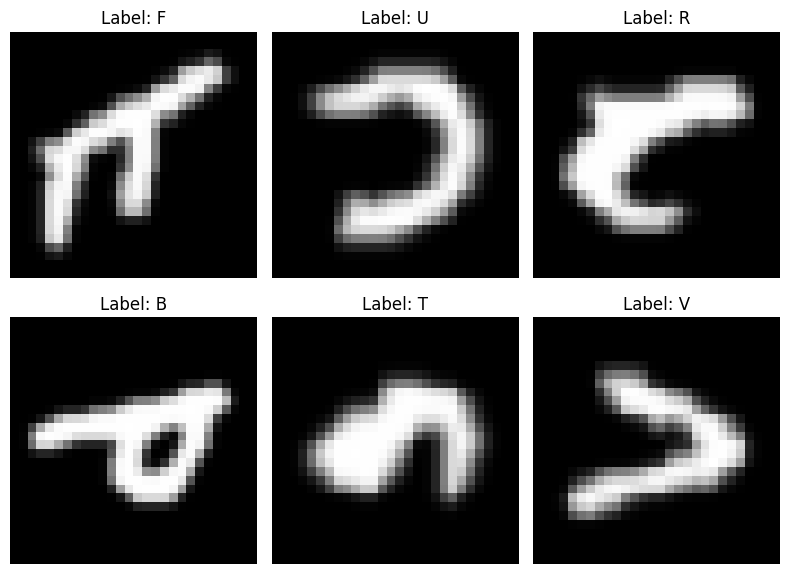

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
for i, example in enumerate(ds_train_proc.unbatch().take(6)):
    image, label = example
    ax = axes[i // 3, i % 3]
    ax.imshow(tf.squeeze(image), cmap='gray')

    label_str = label_map[label.numpy()]

    ax.set_title(f'Label: {label_str}')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Model Definition

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks

def create_cil_model(input_shape=(28,28,1), num_classes=26):
    inp = layers.Input(input_shape)

    # -------- Bloc 1 --------
    x = layers.Conv2D(32, 3, padding='same', name='conv1')(inp)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='act1')(x)
    x = layers.Conv2D(32, 3, padding='same', name='conv1b')(x)
    x = layers.BatchNormalization(name='bn1b')(x)
    x = layers.Activation('relu', name='act2')(x)
    x = layers.MaxPool2D(2, name='pool1')(x)

    # -------- Bloc 2 --------
    x = layers.Conv2D(64, 3, padding='same', name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(2, name='pool2')(x)

    # -------- Embedding --------
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(256, activation='relu', name='features1')(x)
    # x = layers.Dropout(0.5, seed=1337, name='drop1')(x)
    x = layers.Dense(128, activation='relu', name='features2')(x)
    # x = layers.Dropout(0.5, seed=1337, name='drop2')(x)

    # -------- Classificador -------- 
    logits = layers.Dense(num_classes, name='classifier')(x)
    out   = layers.Activation('softmax', name='probabilities')(logits)

    model = models.Model(inp, out)

    for name in ['conv1','bn1','act1','conv1b','bn1b','act2','pool1']:
        model.get_layer(name).trainable = False
    
    # for layer in model.layers:
    #     print(f"{layer.name:15} trainable={layer.trainable}")

    return model

### Training

In [ ]:
# model = tf.keras.models.load_model("models/emnist_model.keras")

In [ ]:
model = create_cil_model()
opt = optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cb = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    ds_train_proc,
    validation_data=ds_val_proc,
    # epochs=20,
    epochs=5,
    callbacks=cb
)

# Final test
test_loss, test_acc = model.evaluate(ds_test_proc)
print(f"Test Acc: {test_acc:.3f}")


## Model Evaluation

In [ ]:
# Evaluate loss and accuracy
test_loss, test_acc = model.evaluate(ds_test_proc)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in ds_test_proc:
    probs = model.predict(images)
    preds = tf.argmax(probs, axis=1).numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map, yticklabels=label_map)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report (Precision, Recall, F1):")
print(classification_report(y_true, y_pred, target_names=label_map))

In [ ]:
for images, labels in ds_test_proc.take(1):  # MUST be the preprocessed dataset
    predictions = model(images)
    pred_labels = tf.argmax(predictions, axis=1)
    
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    for i in range(6):
        ax = axes[i // 3, i % 3]
        ax.imshow(tf.squeeze(images[i]), cmap='gray')

        true_char = label_map[labels[i].numpy()]           # 0–25 → 'A'–'Z'
        pred_char = label_map[pred_labels[i].numpy()]      # 0–25 → 'A'–'Z'

        ax.set_title(f'True: {true_char}, Pred: {pred_char}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### Save Model

In [ ]:
model.save("models/emnist_model.keras")

## Model Wrap

### LittleRTModule

In [12]:
# INFERENCE and TRAINING

class LiteRTModule(tf.Module):
    def __init__(self, model, dropout_rate=0.5, dropout_seed=1337):
        super().__init__()
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy()
        self.dropout_rate = dropout_rate
        self.dropout_seed = dropout_seed

    @tf.function(input_signature=[
        tf.TensorSpec([None, 28, 28, 1], tf.float32, name="images"),
        tf.TensorSpec([None], tf.int64, name="labels")
    ])
    def train(self, images, labels):
        # apply _stateless_ dropout here:
        images = tf.nn.dropout(
            images,
            rate=self.dropout_rate,
            seed=self.dropout_seed
        )
        with tf.GradientTape() as tape:
            logits = self.model(images, training=True)
            loss = self.loss_fn(labels, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))
        return {"loss": loss}

    @tf.function(input_signature=[
        tf.TensorSpec([None, 28, 28, 1], tf.float32, name="images")
    ])
    def infer(self, images):
        probs = self.model(images, training=False)
        return {"probs": probs}

### Create Wraped Model

In [13]:
litert_module = LiteRTModule(model)

### Save Model with Signatures

In [14]:
tf.saved_model.save(
    litert_module,
    "models/lit_saved_model",
    signatures={
        'train': litert_module.train,
        'infer': litert_module.infer
    }
)

INFO:tensorflow:Assets written to: models/lit_saved_model\assets


INFO:tensorflow:Assets written to: models/lit_saved_model\assets


### Convert to TFLitle

In [16]:
COMMON_SUPPORTED_OPS = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

c_train = tf.lite.TFLiteConverter.from_saved_model(
    "models/lit_saved_model",
    signature_keys=["train","infer"]
)
c_train.target_spec.supported_ops = COMMON_SUPPORTED_OPS
c_train.experimental_enable_resource_variables = True
tflite_train = c_train.convert()
open("models/emnist_litert_train.tflite","wb").write(tflite_train)


c_infer = tf.lite.TFLiteConverter.from_keras_model(model)
c_infer.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS ]
c_infer.experimental_enable_resource_variables = False
tflite_inf = c_infer.convert()
open("models/emnist_litert_infer.tflite","wb").write(tflite_inf)

INFO:tensorflow:Assets written to: C:\Users\arnau\AppData\Local\Temp\tmpb98cm3y8\assets


INFO:tensorflow:Assets written to: C:\Users\arnau\AppData\Local\Temp\tmpb98cm3y8\assets


Saved artifact at 'C:\Users\arnau\AppData\Local\Temp\tmpb98cm3y8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2188397028624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397031504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397031888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397032080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397030736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397030352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397030544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397032464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397030928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2188397028432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21883

3473536

## Comparation

In [ ]:
interpreter = tf.lite.Interpreter(model_path="models/emnist_litert_infer.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
x_all = []
y_all = []

# each x_batch is shape (64,28,28,1), each y_batch is (64,)
for x_batch, y_batch in ds_test_proc.take(2):  
    x_all.append(x_batch.numpy())
    y_all.append(y_batch.numpy())

x = np.concatenate(x_all, axis=0)  # -> (128,28,28,1)
y = np.concatenate(y_all, axis=0)  # -> (128,)

# Now exactly like before:
num_samples = 100
keras_logits = model.predict(x[:num_samples])
tflite_logits = []
for i in range(num_samples):
    sample = x[i : i+1].astype(np.float32)      # already has leading batch dim
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    tflite_logits.append(interpreter.get_tensor(output_details[0]['index'])[0])
tflite_logits = np.stack(tflite_logits, axis=0)

keras_preds  = np.argmax(keras_logits, axis=1)
tflite_preds = np.argmax(tflite_logits, axis=1)
keras_acc    = np.mean(keras_preds  == y[:num_samples])
tflite_acc   = np.mean(tflite_preds == y[:num_samples])
avg_diff     = np.mean(np.abs(keras_logits - tflite_logits))
max_diff     = np.max (np.abs(keras_logits - tflite_logits))

print("📊 Model Comparison Summary")
print(f"✅ Keras Accuracy:      {keras_acc:.4f}")
print(f"✅ TFLite Accuracy:     {tflite_acc:.4f}")
print(f"📉 Avg Logit Delta:     {avg_diff:.2e}")
print(f"📈 Max Logit Delta:     {max_diff:.2e}")
